# Cifar10 上的 ReNet18

本文主要介绍在 cifar10 的试验 resnet18 的性能。

导入一些必要包：

In [1]:
import logging
import torch
from torch import nn
from torch.profiler import profile, record_function, ProfilerActivity
from torchvision.models import resnet18, ResNet18_Weights
from torch_book.vision.classifier import Classifier, evaluate_accuracy
from torch_book.datasets.cifar10 import Cifar10
torch.cuda.empty_cache() # 清空 GPU 缓存


logging.basicConfig(filename='logs/debug-graph.log',
                    filemode="w",
                    format='%(asctime)s|%(levelname)s|%(name)s->%(funcName)s@%(message)s',
                    level=logging.INFO)

In [2]:
import torch_book
print(torch_book.__version__)

0.0.10


{mod}`torchvision` 上的 ResNet18 直接用于 cifar10 是不推荐的。需要做以下改动：

```{note}
将 `conv1` 替换以支持 $32 \times 32$ 的输入。同时移除第一个 `maxpool` 避免图片信息过早丢失。
```

In [32]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(model.conv1.in_channels, 
                        model.conv1.out_channels,
                        3, 1, 1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)

## 模块变换

利用 FX 替换全部 {class}`~torch.nn.ReLU` 为 {func}`torch.nn.SiLU`。

In [33]:
import torch
from torch import fx, nn
from torch.nn import functional as F
def replace(model):
    mod = fx.symbolic_trace(model)
    # 遍历 Graph 中全部节点
    for node in mod.graph.nodes:
        # 如果匹配目标
        if node.op == "call_module":
            if "relu" in node.target:
                # 设置插入点，添加新节点，用新节点替换所有 `node` 的用法
                with mod.graph.inserting_after(node):
                    new_node = mod.graph.call_function(F.silu, node.args, node.kwargs)
                    node.replace_all_uses_with(new_node)
                # 移除 graph 中旧的节点
                mod.graph.erase_node(node)
    mod.graph.lint()
    # 不用忘记 recompile！
    new_code = mod.recompile()
    return mod

In [34]:
model = replace(model)

In [35]:
model.graph.print_tabular()

opcode         name                   target                                                      args                                   kwargs
-------------  ---------------------  ----------------------------------------------------------  -------------------------------------  --------
placeholder    x                      x                                                           ()                                     {}
call_module    conv1                  conv1                                                       (x,)                                   {}
call_module    bn1                    bn1                                                         (conv1,)                               {}
call_function  silu                   <function silu at 0x7fb76b4d4f70>                           (bn1,)                                 {}
call_module    maxpool                maxpool                                                     (silu,)                                {}
call_modul

加载数据集：

In [36]:
data = Cifar10(batch_size = 128, num_workers=8, cutout=None)
train_iter = data.train_loader()
test_iter = data.val_loader()

Files already downloaded and verified
Files already downloaded and verified


做一些准备工作：

In [38]:
classifier = Classifier(model, train_iter, test_iter, device=torch.device("cuda:0"))
classifier.prepare_optimizer(lr=0.0142857, momentum=0.857142,
                             weight_decay=0.000857142)
classifier.prepare_scheduler(lr_period=2, lr_decay=0.857142)

训练模型：

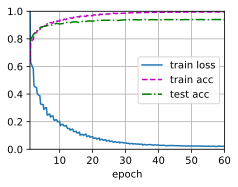

In [39]:
torch._dynamo.reset()
num_epochs = 60
classifier.prepare_animator(num_epochs)
classifier.fit(num_epochs)

In [40]:
test_acc = evaluate_accuracy(classifier.mod, classifier.test_iter, device=torch.device("cuda:0"))
test_acc

0.9387

保存模型（也可以直接 {download}`下载训练权重 <https://github.com/xinetzone/torch-book/releases/download/resnet18_cifar10_relu/resnet18_cifar10_relu.h5>`）：

In [42]:
torch.save(classifier.mod.state_dict(),
           'params/resnet18_cifar10_silu.h5')

## Cutout Cifar10 训练

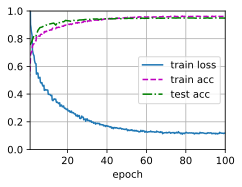

In [44]:
import logging
import torch
from torch import nn
from torch.profiler import profile, record_function, ProfilerActivity
from torchvision.models import resnet18, ResNet18_Weights
from torch_book.vision.classifier import Classifier, evaluate_accuracy
from torch_book.datasets.cifar10 import Cifar10
torch.cuda.empty_cache() # 清空 GPU 缓存
from torch_book.transforms.cutout import Cutout


logging.basicConfig(filename='logs/debug-graph.log',
                    filemode="a",
                    format='%(asctime)s|%(levelname)s|%(name)s->%(funcName)s@%(message)s',
                    level=logging.INFO)

num_epochs = 100
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(model.conv1.in_channels,
                        model.conv1.out_channels,
                        3, 1, 1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)
model = replace(model)
data = Cifar10(batch_size = 64, cutout=Cutout(1, 16), num_workers=8)
train_iter = data.train_loader()
test_iter = data.val_loader()
classifier = Classifier(model, train_iter, test_iter, device=torch.device("cuda:0"))
classifier.prepare_optimizer(lr=0.0142857, momentum=0.857142,
                             weight_decay=0.000857142)
classifier.prepare_scheduler(lr_period=2, lr_decay=0.857142)
classifier.prepare_animator(num_epochs)
classifier.fit(num_epochs)

In [45]:
test_acc = evaluate_accuracy(classifier.mod, classifier.test_iter, device=torch.device("cuda:0"))
test_acc

0.9485

In [49]:
classifier.mod.graph.print_tabular()

opcode         name                   target                                                      args                                   kwargs
-------------  ---------------------  ----------------------------------------------------------  -------------------------------------  --------
placeholder    x                      x                                                           ()                                     {}
call_module    conv1                  conv1                                                       (x,)                                   {}
call_module    bn1                    bn1                                                         (conv1,)                               {}
call_function  silu                   <function silu at 0x7fb76b4d4f70>                           (bn1,)                                 {}
call_module    maxpool                maxpool                                                     (silu,)                                {}
call_modul

In [51]:
torch.save(classifier.mod.state_dict(),
           'params/resnet18_cifar10_silu_cutout.h5')

## 性能度量

In [52]:
inputs = torch.randn(5, 3, 32, 32).type(torch.float32).cuda()       
with profile(activities=[ProfilerActivity.CPU, 
                         ProfilerActivity.CUDA], 
             record_shapes=True) as prof:
    with record_function("model_inference"):
        classifier.mod(inputs)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

STAGE:2023-11-20 19:47:24 2215559:2215559 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        14.88%      35.384ms        99.98%     237.727ms     237.727ms       0.000us         0.00%       1.543ms       1.543ms             1  
                                           aten::conv2d         4.99%      11.856ms        77.42%     184.070ms       9.204ms       0.000us         0.00%       1.377ms      68.850us            20  
         

STAGE:2023-11-20 19:47:25 2215559:2215559 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-11-20 19:47:25 2215559:2215559 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [58]:
new_mod = classifier.mod.eval().cpu()

In [59]:
example_inputs = torch.randn(1, 3, 32, 32)

# 使用 torch.jit.trace 将模型转换为 TorchScript
traced_model = torch.jit.trace(new_mod, example_inputs)

# 保存 TorchScript 模型
torch.jit.save(traced_model, "params/resnet18_cifar10_silu_cutout.pt")